Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [4]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
#from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import BatchNormalization

from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

This assignment uses a dataset of about 2239 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [6]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [7]:
import zipfile
zip_path = '/content/drive/MyDrive/CNN_assignment.zip'
extract_path = '/content/drive/MyDrive/extracted_folder/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [8]:
import pathlib

# Defining the path for train and test images
root_path = '/content/drive/MyDrive/extracted_folder/Skin cancer ISIC The International Skin Imaging Collaboration'
data_dir_train = pathlib.Path(root_path + '/Train/')
data_dir_test = pathlib.Path(root_path + '/Test/')

In [9]:
# Check the number of files in each directory
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Number of train images:", image_count_train)

image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Number of test images:", image_count_test)

Number of train images: 2239
Number of test images: 118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [10]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [11]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [12]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [13]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [14]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

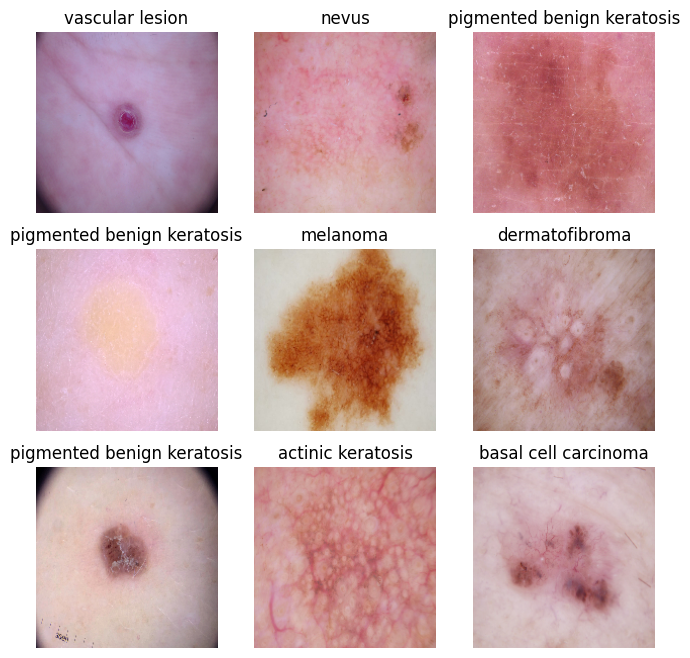

In [15]:
### your code goes here, you can use training or validation data to visualize

# Visualize the images
plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.show()


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [16]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [17]:
### Your code goes here
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))
]

In [18]:
input_shape = (180,180,3)
lr = 1e-5
init = 'normal'
activ = 'relu'

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

## Number of classes is 9
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper (ModuleWrap  (None, 178, 178, 32)      896       
 per)                                                            
                                                                 
 module_wrapper_1 (ModuleWr  (None, 176, 176, 32)      9248      
 apper)                                                          
                                                                 
 module_wrapper_2 (ModuleWr  (None, 88, 88, 32)        0         
 apper)                                                          
                                                                 
 module_wrapper_3 (ModuleWr  (None, 86, 86, 64)        18496     
 apper)                                                 

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [19]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [20]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper (ModuleWrap  (None, 178, 178, 32)      896       
 per)                                                            
                                                                 
 module_wrapper_1 (ModuleWr  (None, 176, 176, 32)      9248      
 apper)                                                          
                                                                 
 module_wrapper_2 (ModuleWr  (None, 88, 88, 32)        0         
 apper)                                                          
                                                                 
 module_wrapper_3 (ModuleWr  (None, 86, 86, 64)        18496     
 apper)                                                 

### Train the model

In [21]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
56/56 [==============================] - 40s 140ms/step - loss: -63099.1992 - accuracy: 0.1713 - val_loss: -43024.7695 - val_accuracy: 0.1499
Epoch 2/15
56/56 [==============================] - 4s 67ms/step - loss: -788569.0000 - accuracy: 0.1724 - val_loss: -896639.1875 - val_accuracy: 0.1499
Epoch 3/15
56/56 [==============================] - 4s 70ms/step - loss: -3215372.7500 - accuracy: 0.1724 - val_loss: -3187425.0000 - val_accuracy: 0.1499
Epoch 4/15
56/56 [==============================] - 4s 65ms/step - loss: -8087430.5000 - accuracy: 0.1724 - val_loss: -8877023.0000 - val_accuracy: 0.1499
Epoch 5/15
56/56 [==============================] - 4s 68ms/step - loss: -16358147.0000 - accuracy: 0.1724 - val_loss: -18972348.0000 - val_accuracy: 0.1499
Epoch 6/15
56/56 [==============================] - 4s 68ms/step - loss: -28650154.0000 - accuracy: 0.1724 - val_loss: -31996754.0000 - val_accuracy: 0.1499
Epoch 7/15
56/56 [==============================] - 4s 70ms/step - los

### Visualizing training results

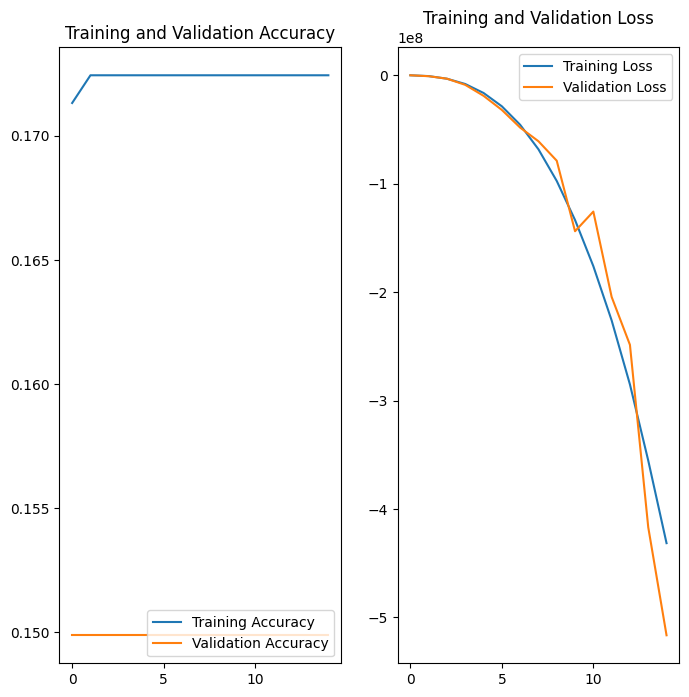

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Let's check if model is Overfit or Underfit

### Write your findings here

In [23]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)


14/14 [==============================] - 0s 21ms/step - loss: -516510624.0000 - accuracy: 0.1499
Accuracy:  0.1724330335855484
Validation Accuracy:  0.14988814294338226
Loss:  -506348640.0
Validation Loss -516510624.0


### Thus we can clearly that model Overfit and we need to chose right data augumentation strategy

In [31]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
data_augument = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
    layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
    layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

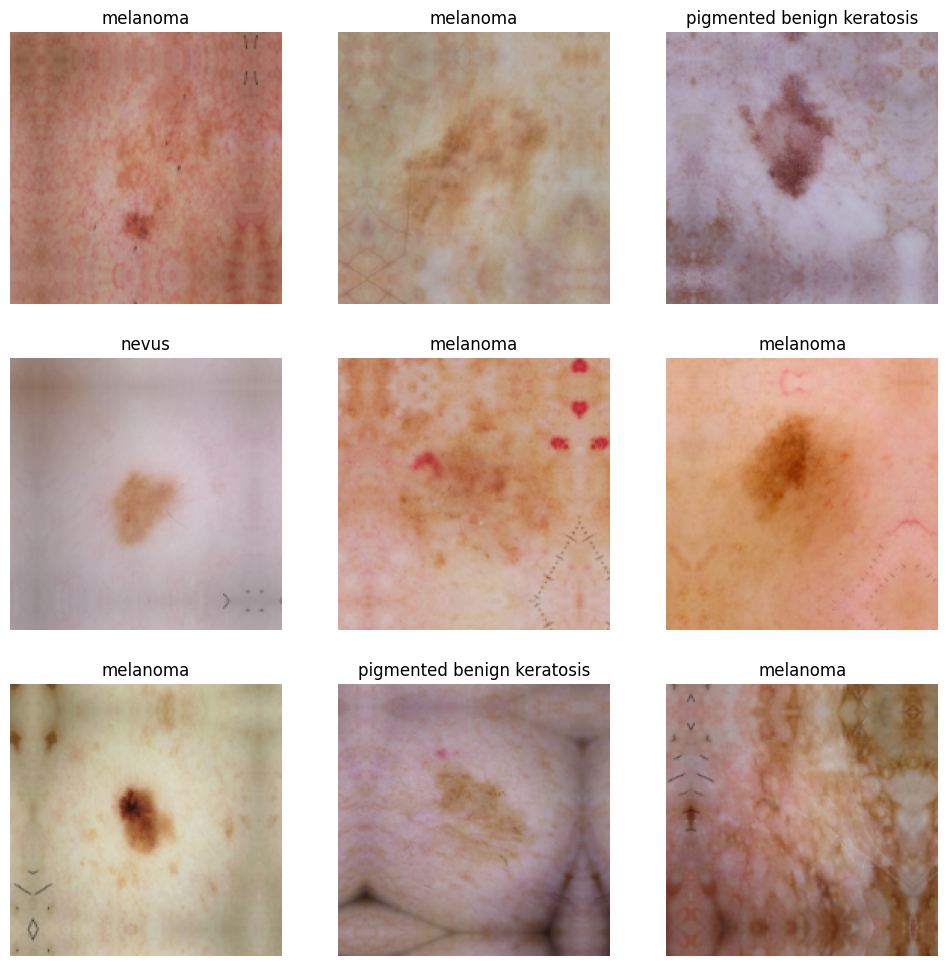

In [32]:
# Todo, visualize how your augmentation strategy works for one instance of the training image.
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
  for index in range(9):
    ax = plt.subplot(3, 3, index + 1)
    plt.imshow(data_augument(images)[index].numpy().astype("uint8"))
    plt.title(class_names[labels[index]])
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [33]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = Sequential([
    data_augument,
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

### Compiling the model

In [34]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [35]:
## Your code goes here, note: train your model for 20 epochs

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs = 20
)

Epoch 1/20
56/56 [==============================] - 10s 111ms/step - loss: 2.0883 - accuracy: 0.1981 - val_loss: 2.0310 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 6s 102ms/step - loss: 2.0371 - accuracy: 0.2076 - val_loss: 2.0235 - val_accuracy: 0.2058
Epoch 3/20
56/56 [==============================] - 7s 117ms/step - loss: 2.0224 - accuracy: 0.2076 - val_loss: 2.0004 - val_accuracy: 0.1946
Epoch 4/20
56/56 [==============================] - 6s 102ms/step - loss: 2.0467 - accuracy: 0.1931 - val_loss: 2.0283 - val_accuracy: 0.2058
Epoch 5/20
56/56 [==============================] - 6s 111ms/step - loss: 2.0263 - accuracy: 0.2109 - val_loss: 2.0456 - val_accuracy: 0.2081
Epoch 6/20
56/56 [==============================] - 6s 101ms/step - loss: 2.0191 - accuracy: 0.1959 - val_loss: 2.0359 - val_accuracy: 0.2081
Epoch 7/20
56/56 [==============================] - 6s 101ms/step - loss: 2.0206 - accuracy: 0.1914 - val_loss: 2.0355 - val_accuracy: 0.1902
Epoch

### Visualizing the results

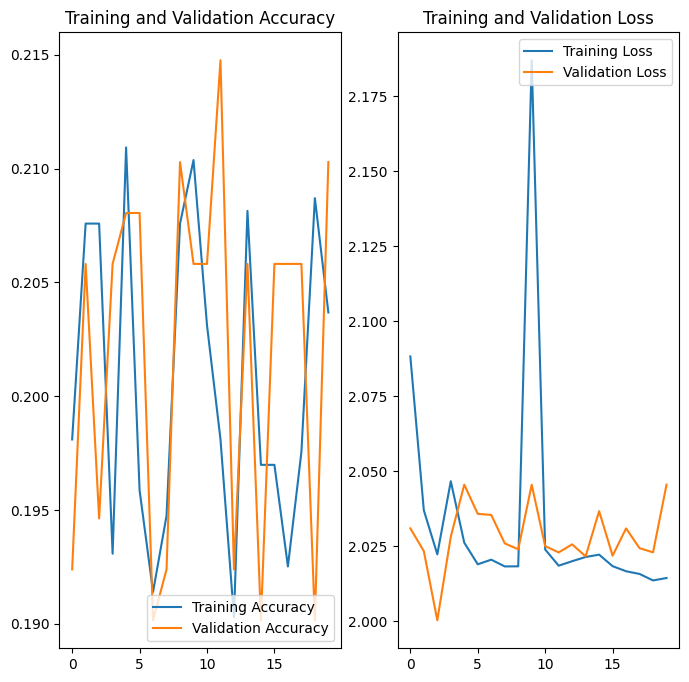

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [37]:
loss1, accuracy1 = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy1)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss1)
print("Validation Loss", loss_v)

14/14 [==============================] - 0s 22ms/step - loss: 2.0456 - accuracy: 0.2103
Accuracy:  0.2064732164144516
Validation Accuracy:  0.2102908343076706
Loss:  2.010720729827881
Validation Loss 2.045614242553711


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [39]:
path_list=[]
lesion_list=[]

for cname in class_names:
  for j in data_dir_train.glob(cname+'/*.jpg'):
    path_list.append(str(j))
    lesion_list.append(cname)

In [40]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/drive/MyDrive/extracted_folder/Skin c...,actinic keratosis
1,/content/drive/MyDrive/extracted_folder/Skin c...,actinic keratosis
2,/content/drive/MyDrive/extracted_folder/Skin c...,actinic keratosis
3,/content/drive/MyDrive/extracted_folder/Skin c...,actinic keratosis
4,/content/drive/MyDrive/extracted_folder/Skin c...,actinic keratosis
...,...,...
2234,/content/drive/MyDrive/extracted_folder/Skin c...,vascular lesion
2235,/content/drive/MyDrive/extracted_folder/Skin c...,vascular lesion
2236,/content/drive/MyDrive/extracted_folder/Skin c...,vascular lesion
2237,/content/drive/MyDrive/extracted_folder/Skin c...,vascular lesion


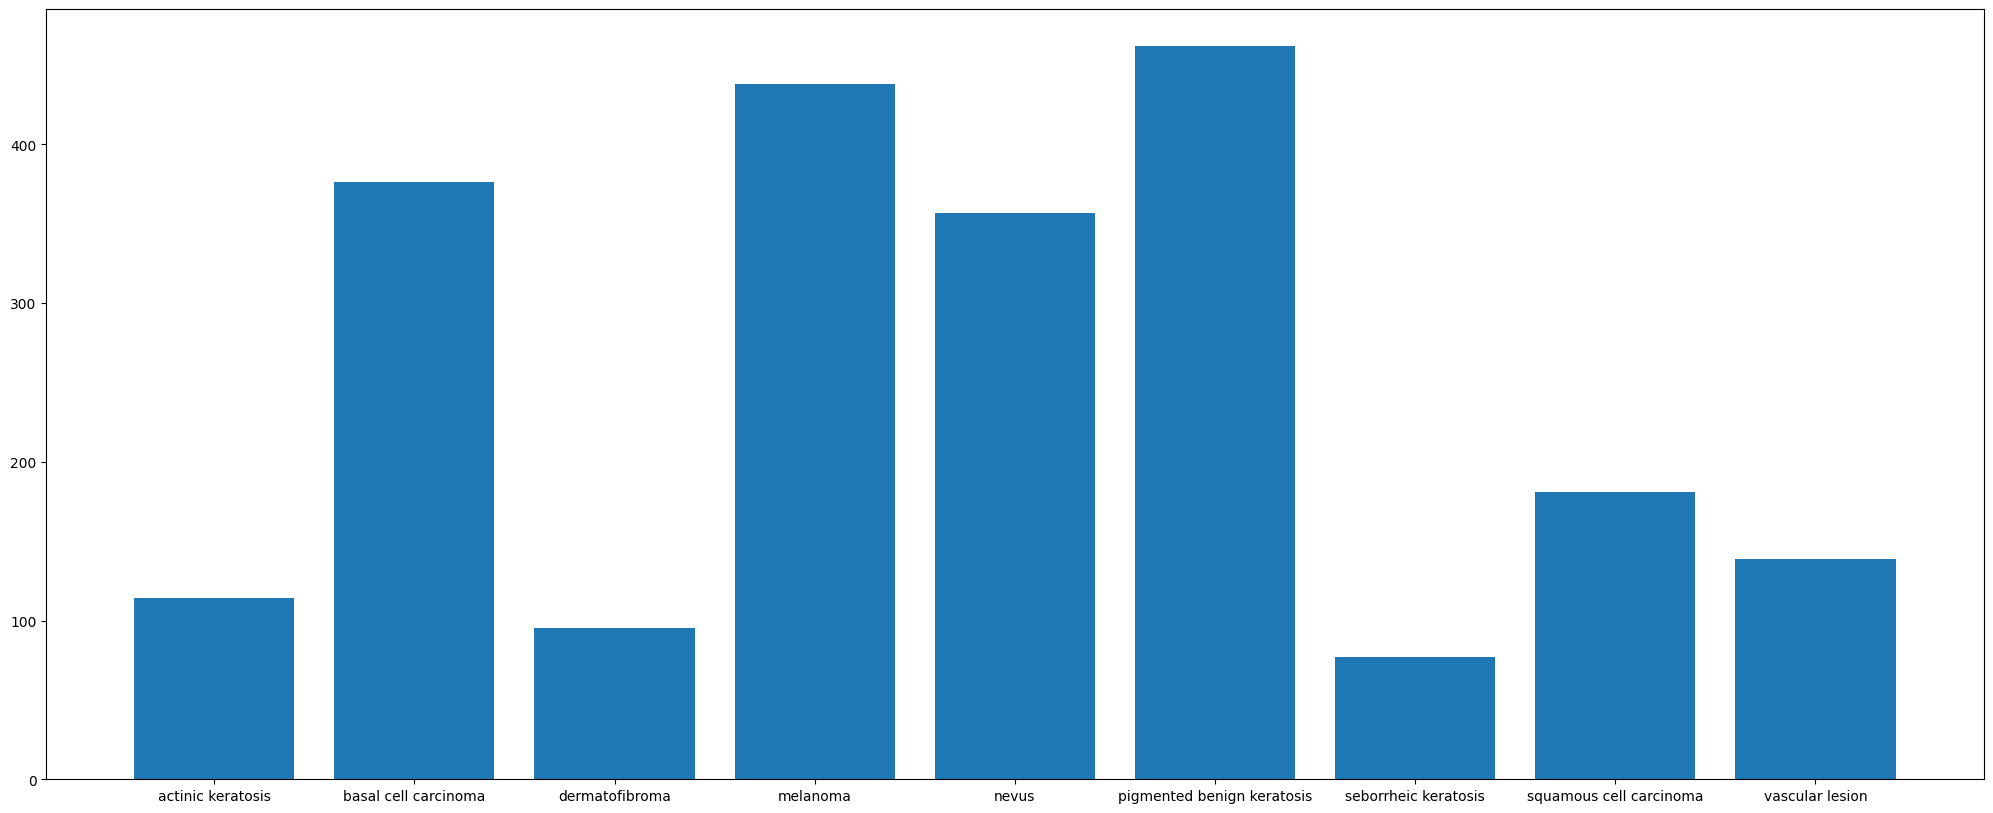

In [41]:
count=[]
for i in class_names:
  count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25, 10))
plt.bar(class_names, count)
plt.show()

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [42]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [43]:
root_path + "/Train"

'/content/drive/MyDrive/extracted_folder/Skin cancer ISIC The International Skin Imaging Collaboration/Train'

In [44]:
path_to_training_dataset= root_path + "/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/extracted_folder/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7986B7123880>: 100%|██████████| 500/500 [00:18<00:00, 27.78 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/extracted_folder/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7987000A7E50>: 100%|██████████| 500/500 [00:18<00:00, 27.51 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/extracted_folder/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7986C816A1D0>: 100%|██████████| 500/500 [00:18<00:00, 27.40 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/extracted_folder/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7986B71B35E0>: 100%|██████████| 500/500 [01:33<00:00,  5.36 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/extracted_folder/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7986B71B2890>: 100%|██████████| 500/500 [01:29<00:00,  5.56 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/extracted_folder/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7986B710B2B0>: 100%|██████████| 500/500 [00:18<00:00, 26.39 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/extracted_folder/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7986C816A1D0>: 100%|██████████| 500/500 [00:39<00:00, 12.61 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/extracted_folder/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7987016BDC00>: 100%|██████████| 500/500 [00:18<00:00, 27.07 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/extracted_folder/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79870159F490>: 100%|██████████| 500/500 [00:18<00:00, 26.32 Samples/s]


In [45]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

### Lets see the distribution of augmented data after adding new images to the original training data.

In [46]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/drive/MyDrive/extracted_folder/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028393.jpg_7fe83c57-e5e8-4827-a773-fc078dd53c6b.jpg',
 '/content/drive/MyDrive/extracted_folder/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031609.jpg_3e1922e2-2b8f-46c3-8787-c96f56699cf7.jpg',
 '/content/drive/MyDrive/extracted_folder/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026040.jpg_da2681ed-a791-4559-9fa0-7c4f8ca201f5.jpg',
 '/content/drive/MyDrive/extracted_folder/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027958.jpg_5e80dea1-02c3-4a53-9b46-9e586e9a775b.jpg',
 '/content/drive/MyDrive/extracted_folder/Skin cancer ISIC The International Skin Imaging Collaboration/Train/ac

In [47]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [48]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [50]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

<ipython-input-50-17a6b079869a>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [51]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [52]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [53]:
data_dir_train = root_path + '/Train'
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset = "training",
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [54]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset = 'validation',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [55]:
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))

])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [56]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [57]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 [==============================] - 44s 246ms/step - loss: 2.1765 - accuracy: 0.1638 - val_loss: 2.0386 - val_accuracy: 0.2554
Epoch 2/50
169/169 [==============================] - 40s 226ms/step - loss: 1.7449 - accuracy: 0.3346 - val_loss: 1.5648 - val_accuracy: 0.4091
Epoch 3/50
169/169 [==============================] - 39s 225ms/step - loss: 1.5722 - accuracy: 0.3997 - val_loss: 1.4855 - val_accuracy: 0.4313
Epoch 4/50
169/169 [==============================] - 39s 221ms/step - loss: 1.5387 - accuracy: 0.4154 - val_loss: 1.4766 - val_accuracy: 0.4120
Epoch 5/50
169/169 [==============================] - 41s 235ms/step - loss: 1.4156 - accuracy: 0.4553 - val_loss: 1.5516 - val_accuracy: 0.4566
Epoch 6/50
169/169 [==============================] - 43s 247ms/step - loss: 1.3409 - accuracy: 0.4846 - val_loss: 1.4293 - val_accuracy: 0.4373
Epoch 7/50
169/169 [==============================] - 38s 220ms/step - loss: 1.3019 - accuracy: 0.5126 - val_loss: 1.4072 - val_accuracy: 0.4

#### **Todo:**  Visualize the model results

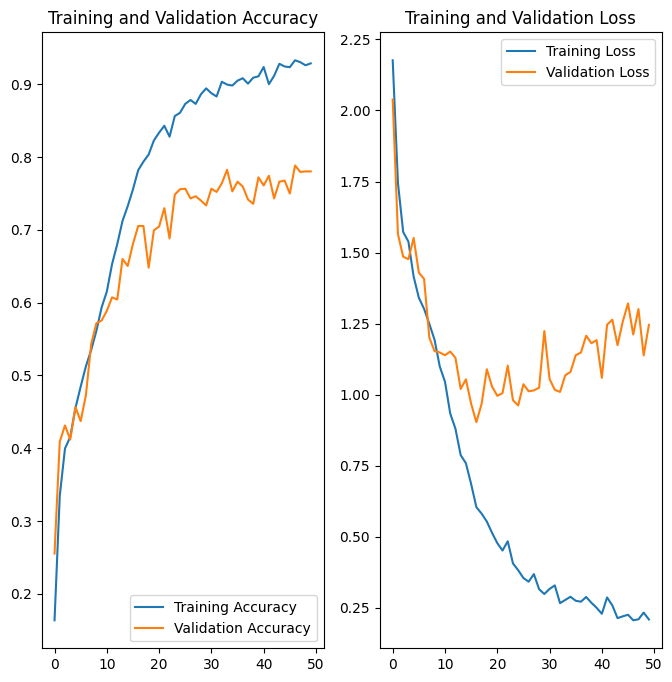

In [58]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?




Accuracy on training data has increased by using the Augmentor library and Model is fitting fine now.
